In [1]:
%matplotlib inline

import sys
sys.path.append("../../ee595")
from deepsea import *

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import binarize
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve

import numpy as np
import scipy as sp
import scipy.io as sio

import h5py

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from keras.models import load_model

sys.path.append("../../IntegratedGradients")
from IntegratedGradients import integrated_gradients

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5005)


In [2]:
def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [3]:
def load_result(files):
    labels = ["acc", "loss", "val_loss", "val_acc"]
    ret = {"acc":[], "loss":[], "val_loss":[], "val_acc":[],}
    for path in files:
        result = load_obj(path)
        for l in labels:
            ret[l] = ret[l] + result[l]
    return ret

# Building the machine learning model

ATACPeak is basically deepsea with ATAC-seq information.
Deepsea is basically deepsea except that you only have 1 output.

In [13]:
def ATACPeak():
    nkernels = [160,240,480]
    in_size = (1,1000,5)
    l2_lam = 5e-07 
    l1_lam = 1e-08 

    model = Sequential()
    model.add(Conv2D(nkernels[0], kernel_size=(1,8), strides=(1,1), padding='same', input_shape=in_size, kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4)))
    model.add(Dropout(0.2))
    
    #expecting 
    #(4,250,320) here

    model.add(Conv2D(nkernels[1], kernel_size=(1,8), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4)))
    model.add(Dropout(0.2))

    model.add(Conv2D(nkernels[1], kernel_size=(1,8), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(919, kernel_regularizer=regularizers.l1(l1_lam)))
    model.add(Activation('relu'))
    model.add(Dense(91, kernel_regularizer=regularizers.l1(l1_lam)))
    model.add(Activation('sigmoid'))
    
    return model

In [14]:
def DeepSEA():
    nkernels = [160,240,480]
    in_size = (1,1000,4)
    l2_lam = 5e-07 
    l1_lam = 1e-08 

    model = Sequential()
    model.add(Conv2D(nkernels[0], kernel_size=(1,8), strides=(1,1), padding='same', input_shape=in_size, kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4)))
    model.add(Dropout(0.2))
    
    #expecting 
    #(4,250,320) here

    model.add(Conv2D(nkernels[1], kernel_size=(1,8), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4)))
    model.add(Dropout(0.2))

    model.add(Conv2D(nkernels[1], kernel_size=(1,8), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(919, kernel_regularizer=regularizers.l1(l1_lam)))
    model.add(Activation('relu'))
    model.add(Dense(91, kernel_regularizer=regularizers.l1(l1_lam)))
    model.add(Activation('sigmoid'))
    
    return model

In [15]:
def ATACtest():
    nkernels = [160,240,480]
    in_size = (1,1000,1)
    l2_lam = 5e-07 
    l1_lam = 1e-08 

    model = Sequential()
    model.add(Conv2D(nkernels[0], kernel_size=(1,8), strides=(1,1), padding='same', input_shape=in_size, kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4)))
    model.add(Dropout(0.2))
    
    #expecting 
    #(4,250,320) here

    model.add(Conv2D(nkernels[1], kernel_size=(1,8), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(1,4), strides=(1,4)))
    model.add(Dropout(0.2))

    model.add(Conv2D(nkernels[1], kernel_size=(1,8), strides=(1,1), padding='same', kernel_regularizer=regularizers.l2(l2_lam)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(919, kernel_regularizer=regularizers.l1(l1_lam)))
    model.add(Activation('relu'))
    model.add(Dense(91, kernel_regularizer=regularizers.l1(l1_lam)))
    model.add(Activation('sigmoid'))
    
    return model

# Loading the data

Preprocessing the data set and saving it to the dat direcotry.

In [58]:
description = [(i.split("\t")[2], i.split("\t")[1]) for i in open("../../ee595/data/deepsea/features.txt").readlines()[1:-1]]
indexes = [(i, description[i][0]) for i in range(len(description)) if description[i][1] == "GM12878"]

In [87]:
# Load training data

train_X, train_Y = loaddata("../../ee595/data/deepsea/", "train")
train_atac = np.load("./traindata-pooled/atactrain.npy")
train_atac = np.expand_dims(train_atac, 1)
trainindex = np.load("traindata-multitask/trainindex.npy")
trainindex = trainindex[:len(trainindex)/2]
train_atac = train_atac[trainindex]
#train_X = train_X[trainindex]
#train_Y = train_Y[trainindex][:,labels]

#train_atac = np.concatenate([train_atac, train_atac], axis=0)[trainindex]
#train_X = np.concatenate([train_X, train_atac], axis=3)

In [11]:
print train_X.shape
print train_Y.shape
np.save("trainx", train_X)
np.save("trainy", train_Y)

(833350, 1, 1000, 4)
(833350, 91)


In [88]:
# Load testing data

test_X, test_Y = loaddata("../../ee595/data/deepsea/", "test")
test_atac = np.load("./traindata-pooled/atactest.npy")
test_atac = np.expand_dims(test_atac, 1)
testindex = np.load("traindata-multitask/testindex.npy")
testindex = testindex[:len(testindex)/2]
test_atac = test_atac[testindex]
#test_X = test_X[testindex]
#test_Y = test_Y[testindex][:,labels]

#test_atac = np.concatenate([test_atac, test_atac], axis=0)[testindex]
#test_X = np.concatenate([test_X, test_atac], axis=3)

In [13]:
print test_X.shape
print test_Y.shape
np.save("testx", test_X)
np.save("testy", test_Y)

(86639, 1, 1000, 4)
(86639, 91)


In [89]:
# Loading validation data

valid_X, valid_Y = loaddata("../../ee595/data/deepsea/", "valid")
valid_atac = np.load("./traindata-pooled/atacvalid.npy")
valid_atac = np.expand_dims(valid_atac, 1)
validindex = np.load("traindata-multitask/validindex.npy")
validindex = validindex[:len(validindex)/2]
valid_atac = valid_atac[validindex]
#valid_X = valid_X[validindex]
#valid_Y = valid_Y[validindex][:,labels]

#valid_atac = np.concatenate([valid_atac, valid_atac], axis=0)[validindex]
#valid_X = np.concatenate([valid_X, valid_atac], axis=3)

In [15]:
print valid_X.shape
print valid_Y.shape
np.save("validx", valid_X)
np.save("validy", valid_Y)

(1420, 1, 1000, 4)
(1420, 91)


In [90]:
np.save("train_atac", train_atac)
np.save("test_atac", test_atac)
np.save("valid_atac", valid_atac)

In [7]:
train_atac = np.load("traindata-multitask/train_atac.npy")
test_atac = np.load("traindata-multitask/test_atac.npy")
valid_atac = np.load("traindata-multitask/valid_atac.npy")

In [92]:
test_X = np.load("traindata-multitask/testx.npy")
train_X = np.load("traindata-multitask/trainx.npy")
valid_X = np.load("traindata-multitask/validx.npy")

(833350, 1, 1000, 1)

In [8]:
test_Y = np.load("traindata-multitask/testy.npy")
train_Y = np.load("traindata-multitask/trainy.npy")
valid_Y = np.load("traindata-multitask/validy.npy")

# Training starts

Deepsea and atacpeak are both trained on the same dataset.

In [25]:
model = ATACPeak()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}-atac-multitask.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [27]:
result = model.fit(train_X, train_Y,
          epochs=10, 
          batch_size=256,
          callbacks=callbacks_list,
          initial_epoch=0, 
          validation_data=(valid_X, valid_Y),
          verbose=0
          )

Epoch 00000: val_loss improved from inf to 0.18467, saving model to weights-improvement-00-0.18-atac-multitask.hdf5
Epoch 00001: val_loss improved from 0.18467 to 0.17545, saving model to weights-improvement-01-0.18-atac-multitask.hdf5
Epoch 00002: val_loss improved from 0.17545 to 0.17193, saving model to weights-improvement-02-0.17-atac-multitask.hdf5
Epoch 00003: val_loss improved from 0.17193 to 0.17149, saving model to weights-improvement-03-0.17-atac-multitask.hdf5
Epoch 00004: val_loss improved from 0.17149 to 0.17122, saving model to weights-improvement-04-0.17-atac-multitask.hdf5
Epoch 00005: val_loss improved from 0.17122 to 0.16950, saving model to weights-improvement-05-0.17-atac-multitask.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve


In [29]:
save_obj(result, "atacpeak-multi")

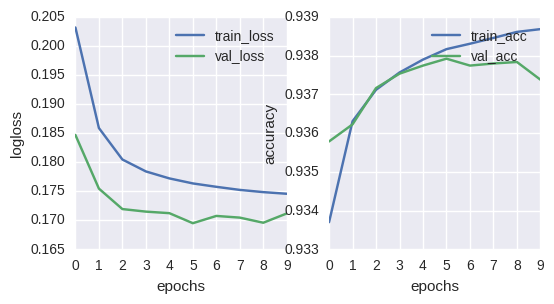

In [28]:
# learning path
result = result.history

plt.figure(figsize=(6,3))
plt.subplot("121")
plt.plot(range(len(result["loss"])), result["loss"], label="train_loss")
plt.plot(range(len(result["val_loss"])), result["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("logloss")
plt.legend()

plt.subplot("122")
plt.plot(range(len(result["acc"])), result["acc"], label="train_acc")
plt.plot(range(len(result["val_acc"])), result["val_acc"], label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

Training deepsea on the same condition

In [19]:
model = DeepSEA()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [20]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}-deepsea.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [21]:
result = model.fit(train_X, train_Y,
          epochs=10, 
          batch_size=256,
          callbacks=callbacks_list,
          initial_epoch=0, 
          validation_data=(valid_X, valid_Y),
          verbose=0)

Epoch 00000: val_loss improved from inf to 0.19233, saving model to weights-improvement-00-0.19-deepsea.hdf5
Epoch 00001: val_loss improved from 0.19233 to 0.18299, saving model to weights-improvement-01-0.18-deepsea.hdf5
Epoch 00002: val_loss improved from 0.18299 to 0.17942, saving model to weights-improvement-02-0.18-deepsea.hdf5
Epoch 00003: val_loss improved from 0.17942 to 0.17807, saving model to weights-improvement-03-0.18-deepsea.hdf5
Epoch 00004: val_loss improved from 0.17807 to 0.17633, saving model to weights-improvement-04-0.18-deepsea.hdf5
Epoch 00005: val_loss improved from 0.17633 to 0.17528, saving model to weights-improvement-05-0.18-deepsea.hdf5
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss improved from 0.17528 to 0.17446, saving model to weights-improvement-09-0.17-deepsea.hdf5


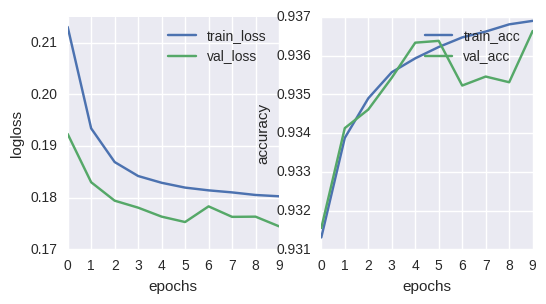

In [24]:
# learning path
#result = load_result(["model/deepsea_history.pkl"])
#result = result.history

plt.figure(figsize=(6,3))
plt.subplot("121")
plt.plot(range(len(result["loss"])), result["loss"], label="train_loss")
plt.plot(range(len(result["val_loss"])), result["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("logloss")
plt.legend()

plt.subplot("122")
plt.plot(range(len(result["acc"])), result["acc"], label="train_acc")
plt.plot(range(len(result["val_acc"])), result["val_acc"], label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

Comparing the minimum trainig loss for both models

In [165]:
result = load_result(["model/deepsea_history.pkl"])
print "DEEPSEA (training loss):", np.min(result["loss"]), str(np.argmin(result["loss"]))+ "th epoch"

result = load_result(["model/atacpeak_history.pkl", "model/atacpeak_history2.pkl"])
print "ATACPEAK (training loss):", np.min(result["loss"]), str(np.argmin(result["loss"]))+ "th epoch"

DEEPSEA (training loss): 0.462422104664 14th epoch
ATACPEAK (training loss): 0.34529576431 19th epoch


In [16]:
model = ATACtest()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}-atactest-multi.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
result = model.fit(train_atac, train_Y,
          epochs=10, 
          batch_size=256,
          callbacks=callbacks_list,
          initial_epoch=0, 
          validation_data=(valid_atac, valid_Y),
          verbose=0)

Epoch 00000: val_loss improved from inf to 0.21326, saving model to weights-improvement-00-0.21-atactest-multi.hdf5
Epoch 00001: val_loss improved from 0.21326 to 0.21283, saving model to weights-improvement-01-0.21-atactest-multi.hdf5
Epoch 00002: val_loss improved from 0.21283 to 0.21139, saving model to weights-improvement-02-0.21-atactest-multi.hdf5
Epoch 00003: val_loss improved from 0.21139 to 0.21100, saving model to weights-improvement-03-0.21-atactest-multi.hdf5


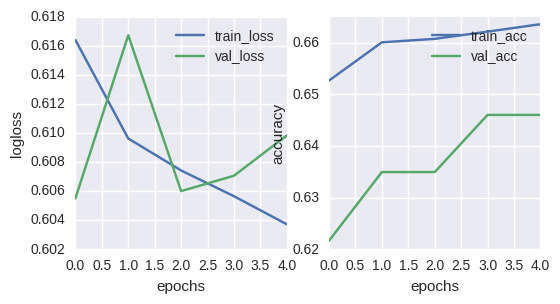

In [25]:
result = result.history

plt.figure(figsize=(6,3))
plt.subplot("121")
plt.plot(range(len(result["loss"])), result["loss"], label="train_loss")
plt.plot(range(len(result["val_loss"])), result["val_loss"], label="val_loss")
plt.xlabel("epochs")
plt.ylabel("logloss")
plt.legend()

plt.subplot("122")
plt.plot(range(len(result["acc"])), result["acc"], label="train_acc")
plt.plot(range(len(result["val_acc"])), result["val_acc"], label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

# Result: ROC curve

Comparing area under ROC curve generated from the test set for deepsea and atacpeak trained on the same model.

In [10]:
test_X2 = np.load("./traindata-multitask/testx.npy")
test_X = np.load("./traindata-multitask/testx-wo-atac.npy")
test_Y = np.load("./traindata-multitask/testy.npy")

atacpeak

In [9]:
model1 = load_model("model/atac-multi-05.hdf5")

In [26]:
# make a prediction
prediction1 = model1.predict(test_X2)

0.815423120633


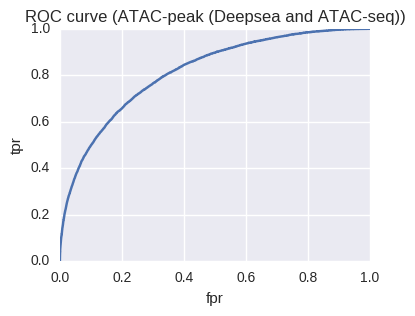

In [36]:
index = 5
fpr, tpr, _ = roc_curve(test_Y[:,index], prediction1[:,index])
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve (ATAC-peak (Deepsea and ATAC-seq))")
print roc_auc_score(test_Y[:,index], prediction1[:,index])

deepsea

In [28]:
model2 = load_model("./model/DeepSEA-91multitask.hdf5")

In [29]:
prediction2 = model2.predict(test_X)

0.80859304301


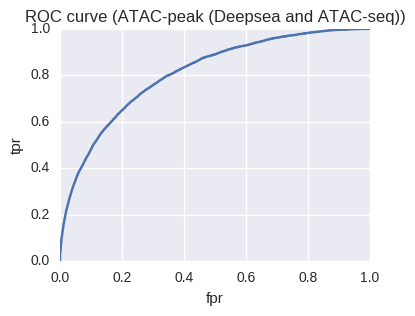

In [37]:
index = 5
fpr, tpr, _ = roc_curve(test_Y[:,index], prediction2[:,index])
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve (ATAC-peak (Deepsea and ATAC-seq))")
print roc_auc_score(test_Y[:,index], prediction2[:,index])

In [39]:
x = []
y = []
for i in range(91):
    x.append(roc_auc_score(test_Y[:,i], prediction1[:,i]))
    y.append(roc_auc_score(test_Y[:,i], prediction2[:,i]))

In [82]:
np.mean(x)-np.mean(y)

0.0037656599635469412

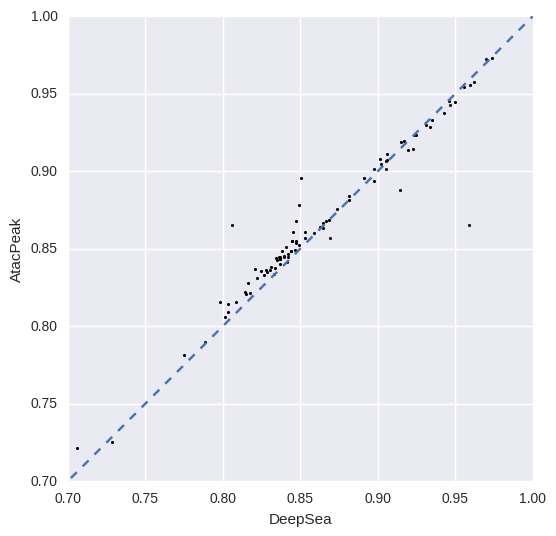

In [53]:
plt.figure(figsize=(6,6))
plt.scatter(y,x,linewidth=0,marker='.',c="black")
plt.plot([0,1],[0,1],ls="--")
plt.xlim(0.70,1.00)
plt.ylim(0.70,1.00)
plt.ylabel("AtacPeak")
plt.xlabel("DeepSea")

ATAC-seq alone

In [28]:
prediction3 = model.predict(test_atac)

0.712546512755


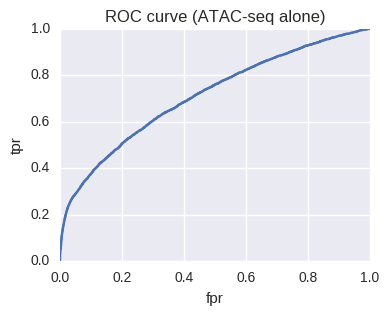

In [32]:
fpr, tpr, _ = roc_curve(test_Y, prediction3)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve (ATAC-seq alone)")
print roc_auc_score(test_Y, prediction3)

# Explaining ATACpeak

Integrated gradients explanation of deepsea and ATACpeak models.

In [72]:
index = [i for i in range(test_Y.shape[0]) if test_Y[i,0] == 1 and prediction1[i,0] > 0.9]

In [63]:
ig = integrated_gradients(model1, verbose=0, outchannels=[0])

In [73]:
len(index)

11

position 74
position 1386
position 12672
position 34557
position 43810
position 55549
position 56093
position 72765
position 74681
position 81387
position 82071


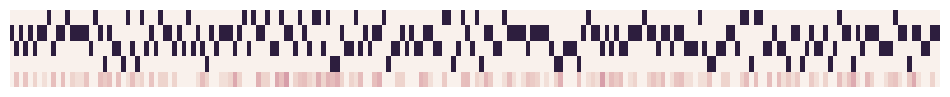

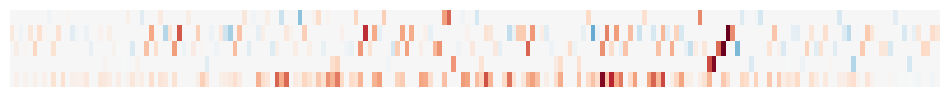

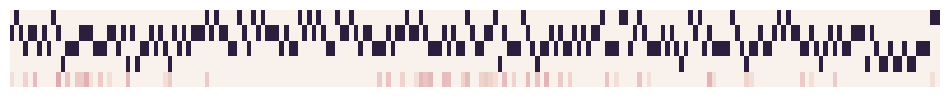

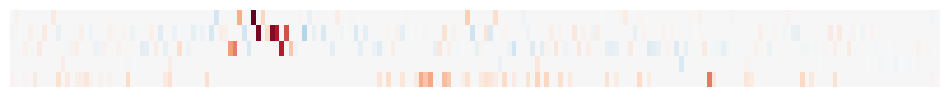

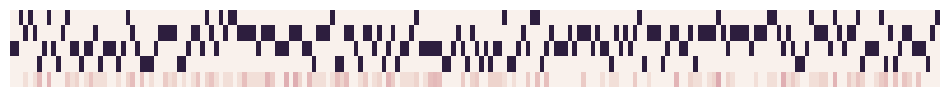

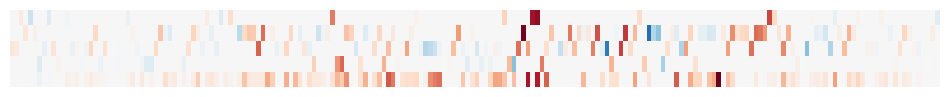

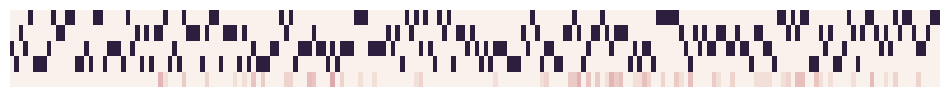

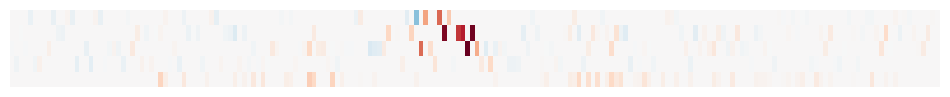

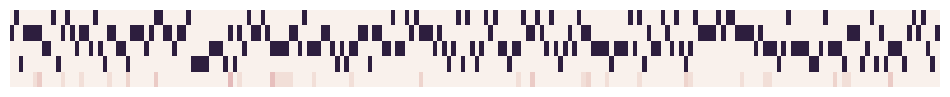

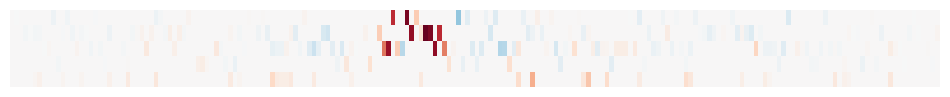

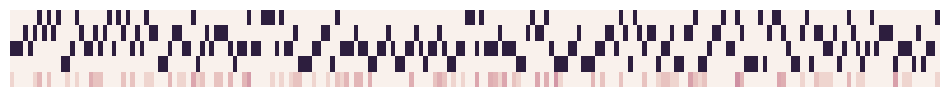

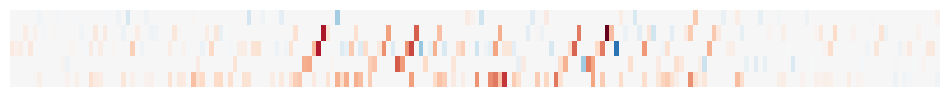

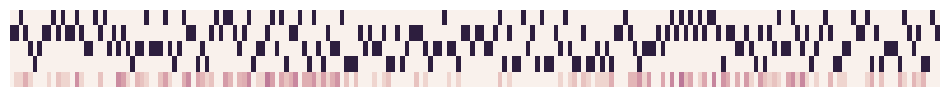

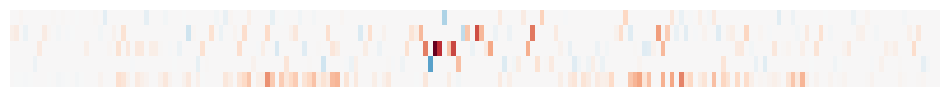

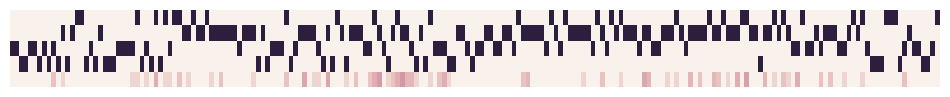

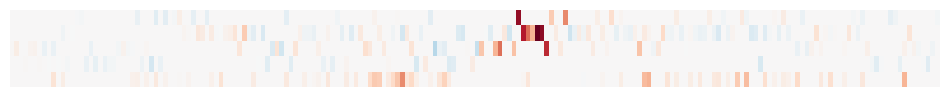

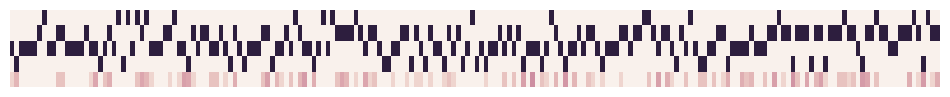

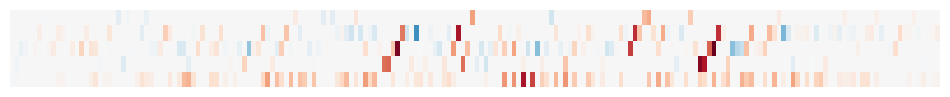

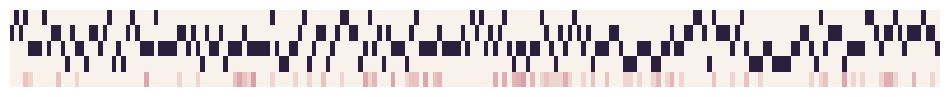

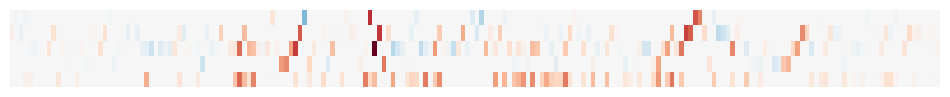

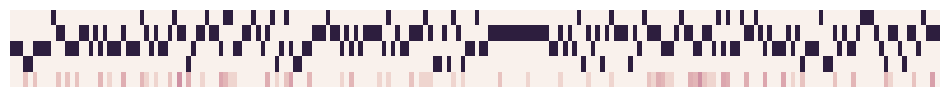

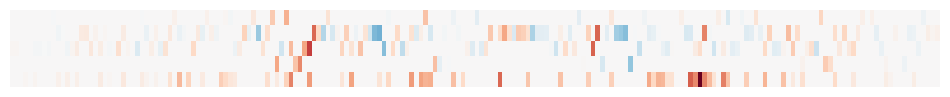

In [79]:
for i in index:
    print "position", i
    
    plt.figure(figsize=(12,1))
    sns.heatmap(np.transpose(test_X2[i][0,400:600,:]), cbar=False)
    plt.yticks([],[])
    plt.xticks([],[])
    
    ex = ig.explain(test_X2[i])[0][400:600]
    plt.figure(figsize=(12,1))
    sns.heatmap(np.transpose(ex), cbar=False)
    plt.yticks([],[])
    plt.xticks([],[])

# Explaining ATAC-seq alone model

In [43]:
ig = integrated_gradients(model, verbose=0)

index: 5414
index: 5725
index: 6951
index: 7030
index: 7057


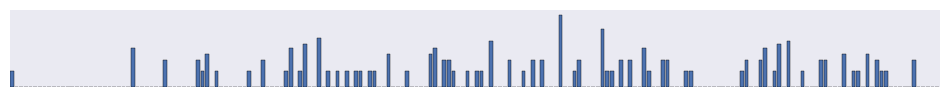

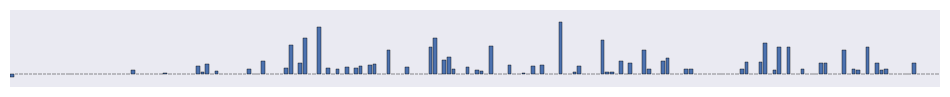

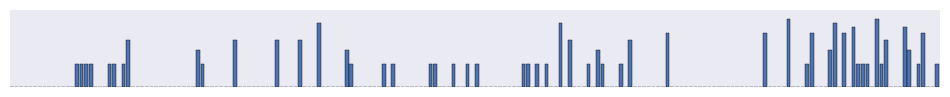

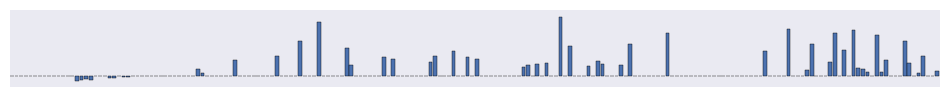

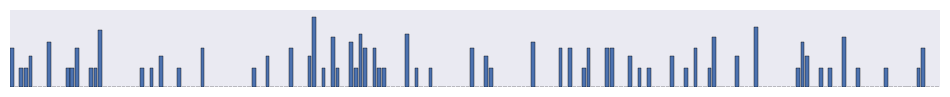

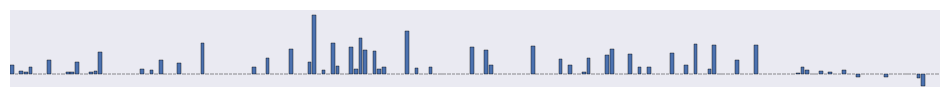

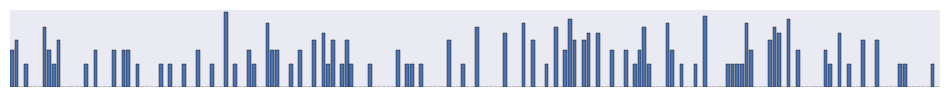

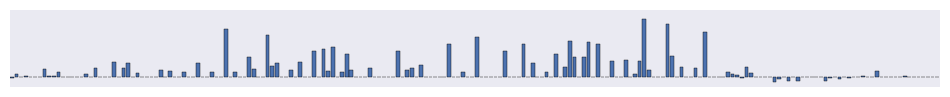

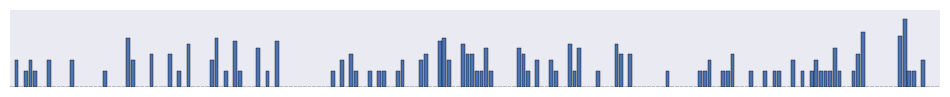

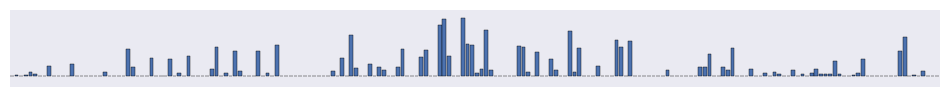

In [48]:
for i in index[:5]:
    print "index:", i
    plt.figure(figsize=(12,1))
    plt.bar(range(200), test_atac[i][0,400:600,0])
    plt.yticks([],[])
    plt.xticks([],[])
    
    ex = ig.explain(test_atac[i])[0][400:600]
    plt.figure(figsize=(12,1))
    plt.bar(range(200), ex)
    #sns.heatmap(np.transpose(ex), cbar=False)
    plt.yticks([],[])
    plt.xticks([],[])

# Explaining DeepSea alone 

In [50]:
ig = integrated_gradients(model2, verbose=0)

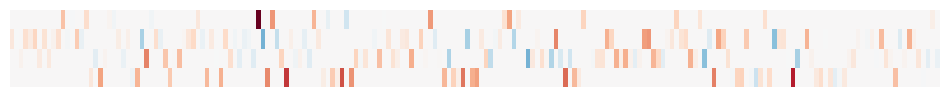

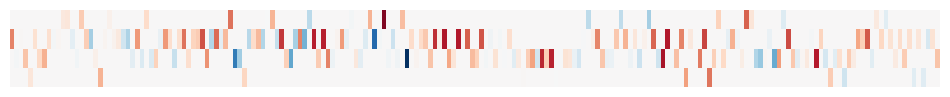

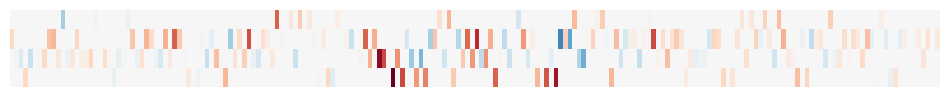

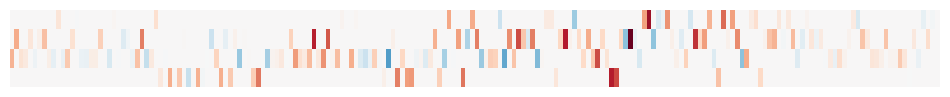

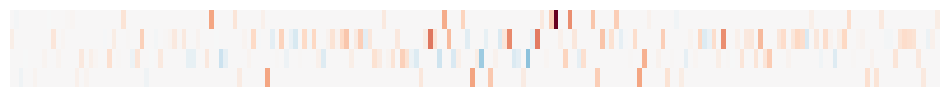

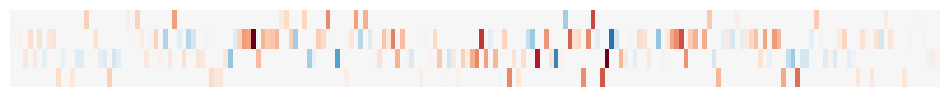

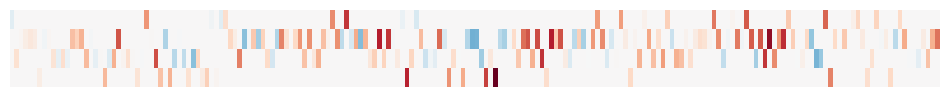

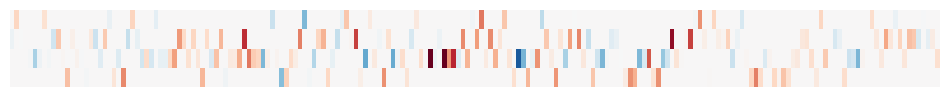

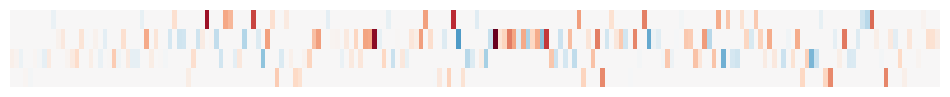

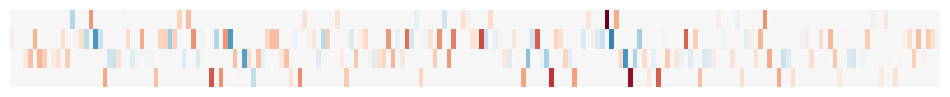

In [51]:
for i in index[:10]:
    
    ex = ig.explain(test_X[i])[0][400:600]
    plt.figure(figsize=(12,1))
    sns.heatmap(np.transpose(ex), cbar=False)
    plt.yticks([],[])
    plt.xticks([],[])

# multi task DeepSEA

In [52]:
model2 = load_model("../../ee595/models/deepsea/weights-improvement-09-0.06-full.hdf5")

In [54]:
ig = integrated_gradients(model2, verbose=0, outchannels=[2])

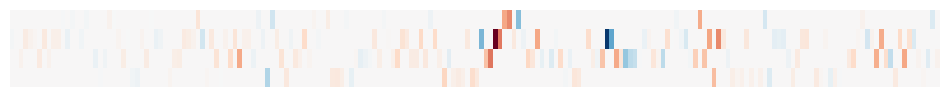

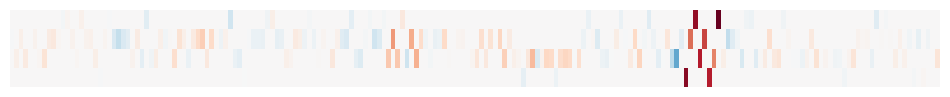

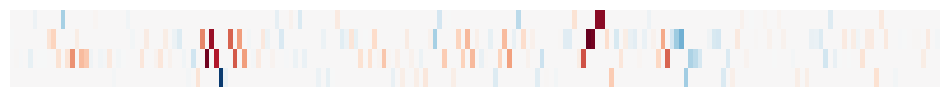

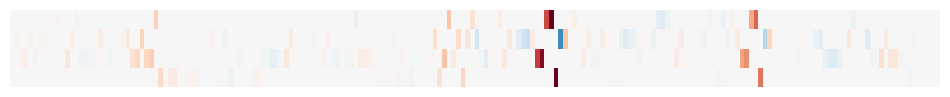

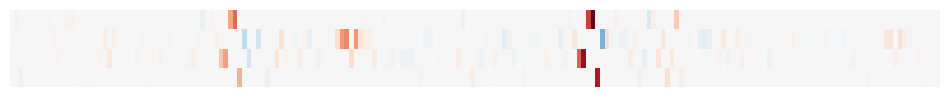

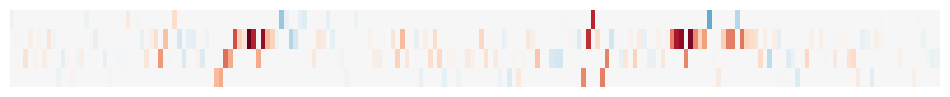

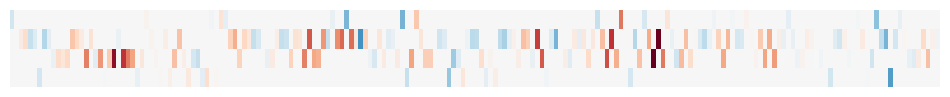

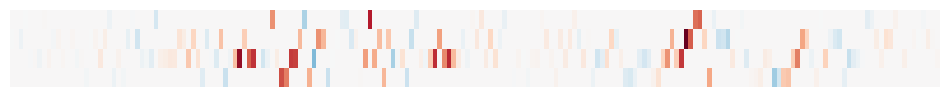

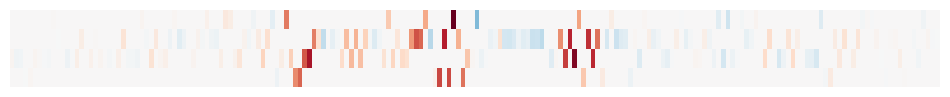

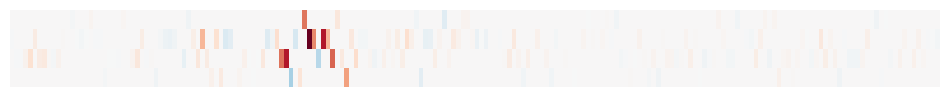

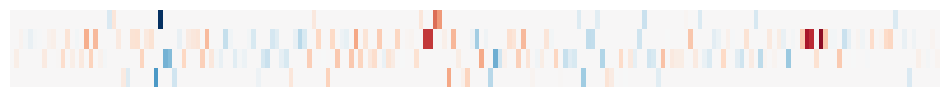

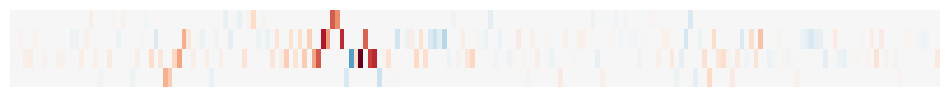

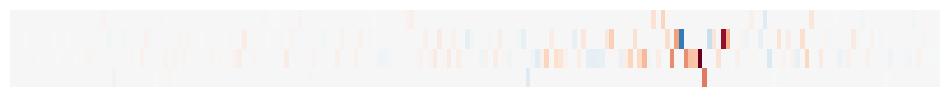

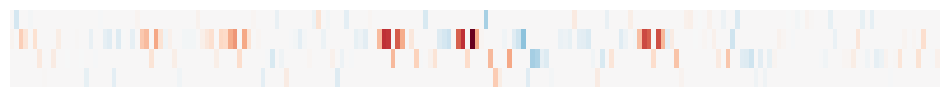

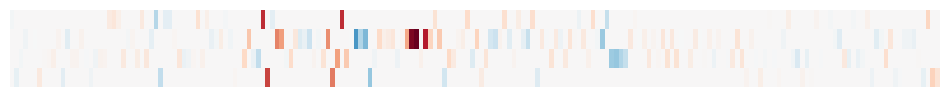

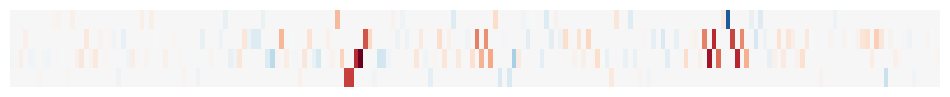

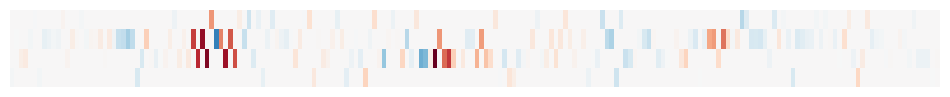

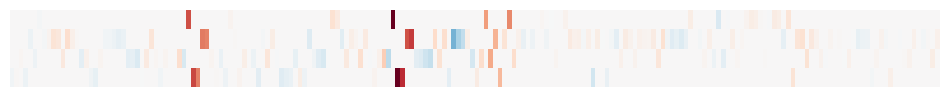

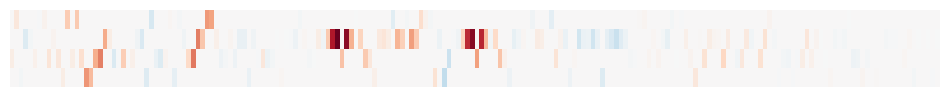

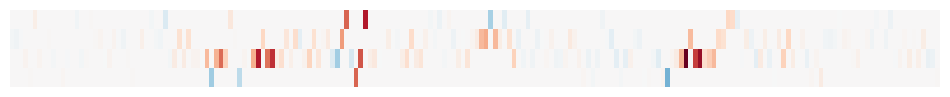

In [56]:
for i in index[:20]:
    
    ex = ig.explain(test_X[i])[0][400:600]
    plt.figure(figsize=(12,1))
    sns.heatmap(np.transpose(ex), cbar=False)
    plt.yticks([],[])
    plt.xticks([],[])